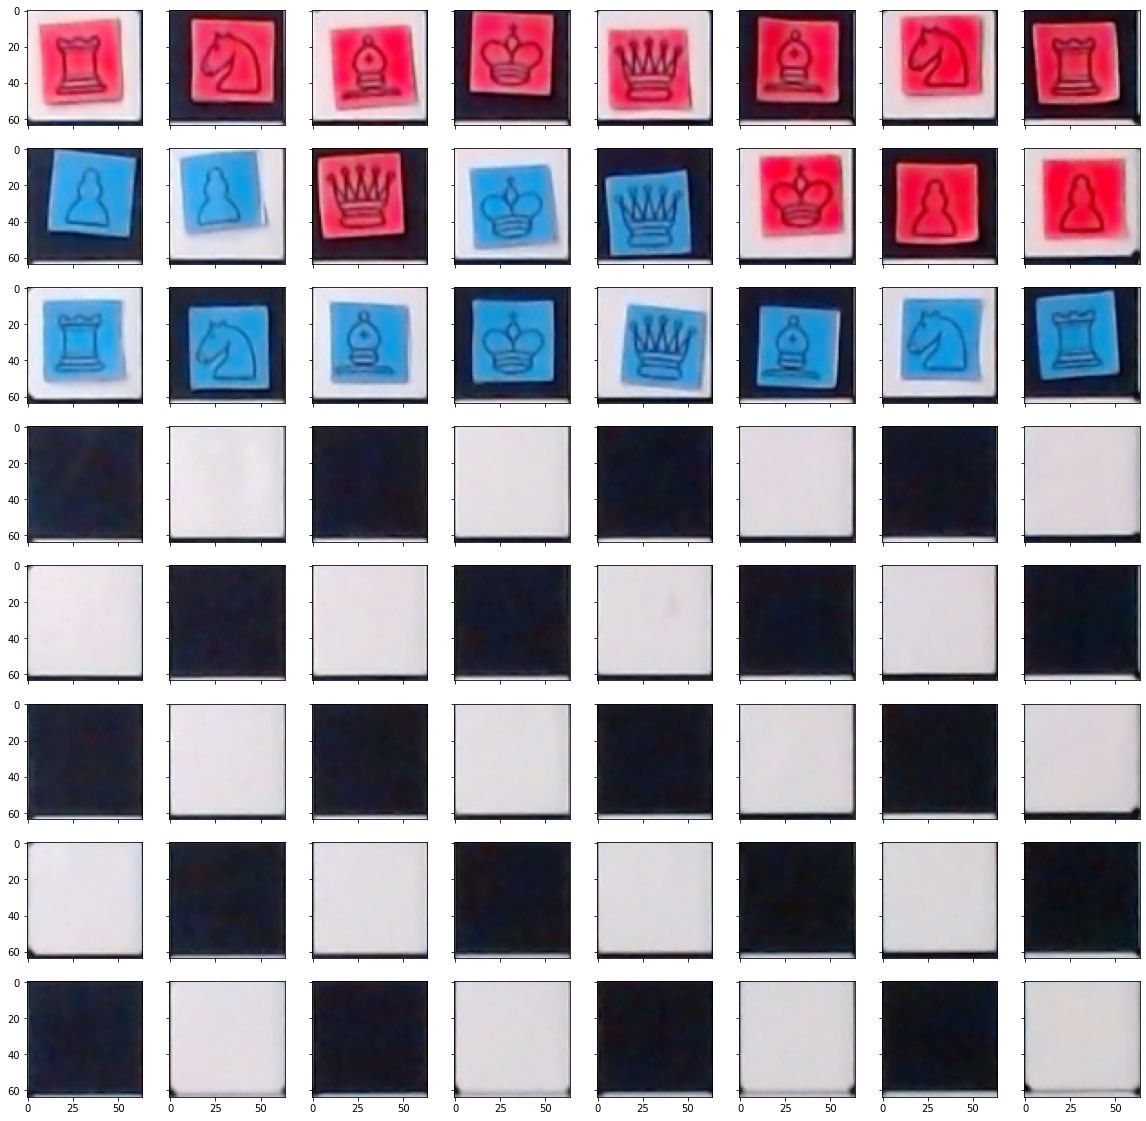

In [1]:
import torch

import cv2 as cv
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from torchvision.transforms import ToTensor

img = cv.imread('original.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

rows, cols, ch = img.shape
pts1 = np.float32([[58, 116], [698, 102], [28, 718], [739, 718]])
pts2 = np.float32([[0,0],[512,0],[0,512],[512,512]])

M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img,M,(512,512))

fig, axes = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True, figsize=(20,20))

squares = []
for i in range(8):
    for j in range(8):
        img2 = dst[64*i:64*i + 64, 64*j:64*j + 64]
        squares.append(img2)
        axes[i][j].imshow(img2)

2b5/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR
torch.return_types.max(
values=tensor([3423.3948, 2239.6475, 5218.7246, 1405.4371, 4894.1548, 2252.0747,
        3714.0020, 2932.5320, 5673.2192, 4919.8711, 3073.9089, 4651.8184,
        1967.9740, 3620.0845, 3694.7732, 3041.2505, 4212.4614, 4133.9932,
        3777.2922, 3606.9495, 3387.5923, 4477.2769, 5153.7808, 6463.8047,
        1225.0133, 7192.2021,  996.5225, 8601.1611,  838.7037, 6997.9048,
         919.1447, 7545.1050, 8153.9536,  976.8367, 6124.6597,  791.1930,
        5895.8354,  763.6277, 7604.4922,  856.7391, 1039.4696, 6858.6934,
        1112.0162, 7190.7178,  962.0174, 7850.0737,  978.6461, 5745.8784,
        8665.9043,  832.9136, 6906.1089, 1003.9510, 7449.8135,  795.4956,
        6892.7437, 1063.8207, 1276.7736, 7706.4458,  663.7081, 7246.7280,
         941.8850, 6999.9224, 1077.3143, 5948.8232], grad_fn=<MaxBackward0>),
indices=tensor([13, 13, 13, 11,  9, 11,  3, 13,  6,  6,  9,  6,  8, 11,  7, 13,  6,  2,
         0,  6

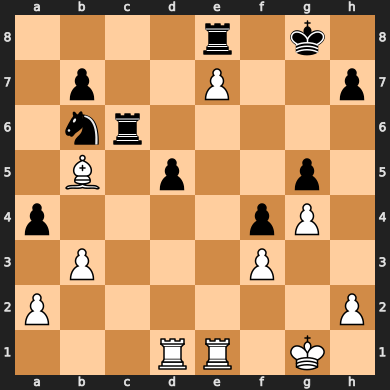

In [2]:
squares = np.array(squares)
squares = squares.transpose((0, 3, 1, 2))
x = torch.from_numpy(squares).float()

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(4,4)
        # First conv layers
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256,512, 7, padding=3)
        #self.conv5 = nn.Conv2d(12,6, 3, padding=1)
        #self.conv6 = nn.Conv2d(6,3, 1, padding=0)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 14)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        x = F.relu(self.conv4(x))
        
        x = self.pool4(x)
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        x = x.view(x.shape[0], -1)
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# initialize the NN
model = ConvAutoencoder()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))

mapping = {'alfil_azul': 0, 'alfil_rojo': 1, 'caballo_azul': 2, 'caballo_rojo': 3, 'fondo_blanco': 4, 'fondo_negro': 5, 'peon_azul': 6, 'peon_rojo': 7, 'reina_azul': 8, 'reina_rojo': 9, 'rey_azul': 10, 'rey_rojo': 11, 'torre_azul': 12, 'torre_rojo': 13}

rev_mapping = {v:k for k,v in mapping.items()}


def idx2piece(idx):
    return get_piece(rev_mapping[idx.item()])

def get_piece(piece):
        return {
            'alfil_azul': 'b',
            'alfil_rojo': 'B',
            'caballo_azul': 'n',
            'caballo_rojo': 'N',
            'peon_azul': 'p',
            'peon_rojo': 'P',
            'reina_azul': 'q',
            'reina_rojo': 'Q',
            'rey_azul': 'K',
            'rey_rojo': 'k',
            'torre_azul': 'r',
            'torre_rojo': 'R'
        }.get(piece, '.')

get_piece_ = lambda piece: {".": False}.get(piece, piece)
    
def from_board_to_fne(board):
    fne_board = []
    # 'for loop' until the shape is defined
    for row in board.splitlines():
        fne_row = ""
        empty_spaces = 0
        for piece in row:
            piece = get_piece_(piece)
            if piece:
                if empty_spaces:
                    fne_row += str(empty_spaces)
                    fne_row += piece
                else:
                    fne_row += piece

                empty_spaces = 0
            else:
                empty_spaces += 1

        if empty_spaces:
            fne_row += str(empty_spaces)

        fne_board.append(fne_row)

    return "/".join(fne_board)[1:]

from itertools import groupby
def board2fne(board):
    for row in board:
        for k, g in groupby(row):
            print(k,g)

board = """
..b.....
pppp.Qpp
..n..n..
....p...
..B.P...
........
PPPP.PPP
RNB.K.NR
"""

print(from_board_to_fne(board))

y = model(x)
y = model(x)
y = torch.max(y, 1)

print(y)


import chess
import chess.svg
import chess.engine

board = [[None for j in range(8)] for j in range(8)]
for i, piece in enumerate(map(idx2piece,y.indices)):
    board[i % 8][i // 8] = piece
    
board = '\n'.join(str(''.join(row)) for row in board)
board_str = '\n' + board
board_fen = from_board_to_fne(board_str)
board_fen = "4r1k1/1p2P2p/1nr5/1B1p2p1/p4pP1/1P3P2/P6P/3RR1K1"

limit = chess.engine.Limit(time=2.0)

board_white = chess.Board(f'{board_fen} w')
board_black = chess.Board(f'{board_fen} b')

board_white